## Data Loading

In [1]:
from DecisionTree import DecisionTree
from CrossValidator import KFoldCrossValidator
from TreeEvaluator import TreeEvaluator
import numpy as np

## Loading datasets
clean_data = np.loadtxt('wifi_db/clean_dataset.txt')
noisy_data = np.loadtxt('wifi_db/noisy_dataset.txt')

## Last column is the label, which we should convert to int
clean_labels = clean_data[:, -1].astype(int)
noisy_labels = noisy_data[:, -1].astype(int)

clean_data = np.column_stack((clean_data[:, :-1], clean_labels))
noisy_data = np.column_stack((noisy_data[:, :-1], noisy_labels))

## check shape, we expect these to be the same
print(f"Clean data shape: {clean_data.shape}")
print(f"Noisy data shape: {noisy_data.shape}")

print(f"First row of clean data: {clean_data[0]}")
print(f"First row of noisy data: {noisy_data[0]}")

Clean data shape: (2000, 8)
Noisy data shape: (2000, 8)
First row of clean data: [-64. -56. -61. -66. -71. -82. -81.   1.]
First row of noisy data: [-59. -53. -51. -54. -45. -79. -87.   4.]


## Train Tree on Full Dataset

In [2]:
## We expect the tree to achieve 100% accuracy on the provided training data
tree = DecisionTree(clean_data)
tree.train(max_depth=None)  # No max depth, fully grow the tree
avg_acc = TreeEvaluator.evaluate(clean_data, tree)
assert avg_acc == 1.0, f"Expected 100% accuracy on clean training data but got {avg_acc}"
print(f"Tree achieved 100% accuracy on training data.\nTree depth on clean data: {tree.depth}")

Tree achieved 100% accuracy on training data.
Tree depth on clean data: 14


## Visualise Tree Structure

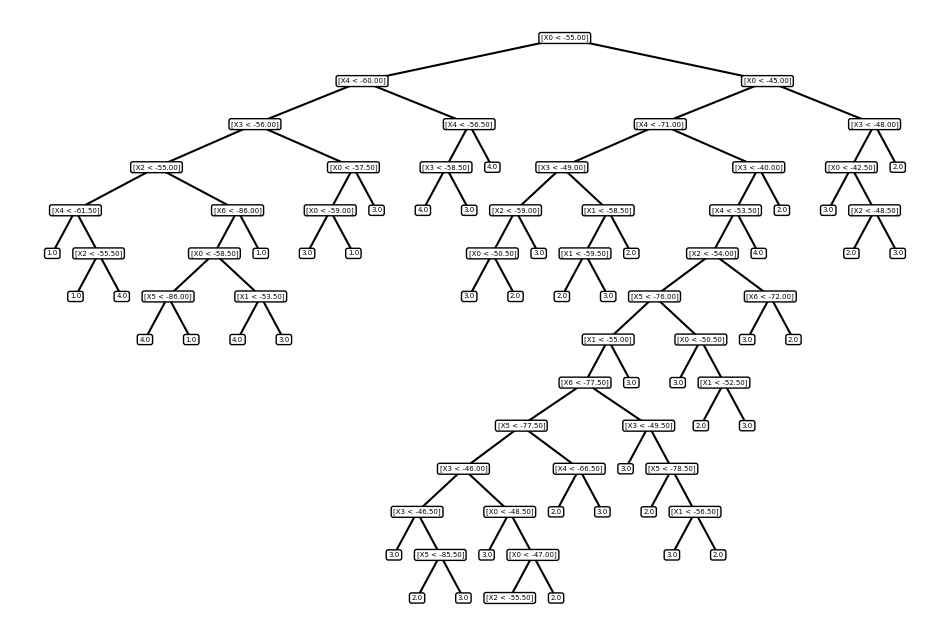

In [5]:
plt = tree.visualise(1, tree.depth)
plt.show()

In [5]:
top_k_features = tree.get_top_k_features(k=5)
for feature_idx, importance_score in top_k_features:
    print(f"Feature {feature_idx} - Importance Score: {importance_score}")

Feature 0 - Importance Score: 1.2874718874763276
Feature 4 - Importance Score: 0.5576768252541117
Feature 3 - Importance Score: 0.08514079064495307
Feature 2 - Importance Score: 0.02490609564830657
Feature 6 - Importance Score: 0.015241148829463275


## 10 Fold Cross Validation

In [9]:
tenFoldValidator = KFoldCrossValidator(DecisionTree, 10)


def process_metrics(metrics):
    # calculate precision, recall, f1 from confusion matrix
    confusion_matrix = metrics["avg_confusion_matrix"]
    label_to_index = metrics["label_to_index"]
    precision_dict, recall_dict = TreeEvaluator.get_precision_recall_per_class(
        confusion_matrix, label_to_index)
    per_label_f1 = {}
    for label in label_to_index.keys():
        f1 = TreeEvaluator.get_f1_score(precision_dict[label], recall_dict[label])
        per_label_f1[label] = f1
    metrics["precision"] = precision_dict
    metrics["recall"] = recall_dict
    metrics["f1_score"] = per_label_f1


## We expect the accuracies here to be different each time due to randomness in fold splitting
print("Performing 10-Fold Cross Validation on clean data:")
clean_metrics = tenFoldValidator.k_fold_cross_validation(clean_data)
process_metrics(clean_metrics)
print("Average Accuracy on clean data:", clean_metrics["average_accuracy"])

# Python's maximum recursion depth is usually 1000
# The tree could sometimes exceed this depth on noisy data, leading to a RecursionError
# So we set a max depth of 1000 for noisy data
print("\nPerforming 10-Fold Cross Validation on noisy data:")
noisy_metrics = tenFoldValidator.k_fold_cross_validation(noisy_data, tree_depth=1000)
process_metrics(noisy_metrics)
print("Average Accuracy on noisy data:", noisy_metrics["average_accuracy"])

Performing 10-Fold Cross Validation on clean data:
Fold 1: Accuracy = 0.9500
Fold 2: Accuracy = 0.9800
Fold 3: Accuracy = 0.9750
Fold 4: Accuracy = 0.9600
Fold 5: Accuracy = 0.9650
Fold 6: Accuracy = 0.9800
Fold 7: Accuracy = 0.9750
Fold 8: Accuracy = 0.9700
Fold 9: Accuracy = 0.9700
Fold 10: Accuracy = 0.9900
Average Accuracy on clean data: 0.9715

Performing 10-Fold Cross Validation on noisy data:
Fold 1: Accuracy = 0.7400
Fold 2: Accuracy = 0.7600
Fold 3: Accuracy = 0.7400
Fold 4: Accuracy = 0.8200
Fold 5: Accuracy = 0.8050
Fold 6: Accuracy = 0.8150
Fold 7: Accuracy = 0.7900
Fold 8: Accuracy = 0.7900
Fold 9: Accuracy = 0.8300
Fold 10: Accuracy = 0.7750
Average Accuracy on noisy data: 0.7865


## Result Visualisation

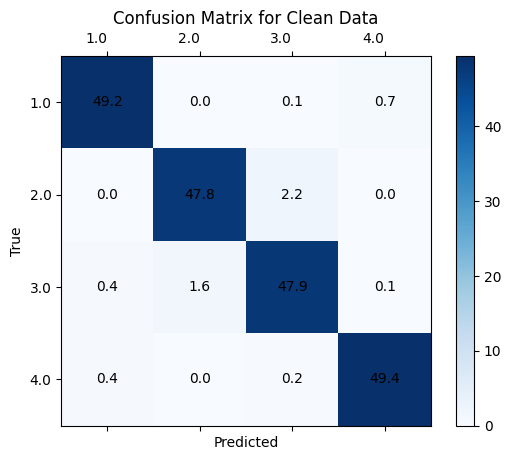

Results Summary for Clean Data:
Average Accuracy: 0.9715
Precision per class:
  Class 1: 0.9840000000000001
  Class 2: 0.9676113360323886
  Class 3: 0.9503968253968254
  Class 4: 0.9840637450199203
  Average Precision: 0.9715179766122837
Recall per class:
  Class 1: 0.9839999999999999
  Class 2: 0.956
  Class 3: 0.958
  Class 4: 0.988
  Average Recall: 0.9714999999999999
F1 Score per class:
  Class 1: 0.984
  Class 2: 0.9617706237424547
  Class 3: 0.9541832669322708
  Class 4: 0.9860279441117764



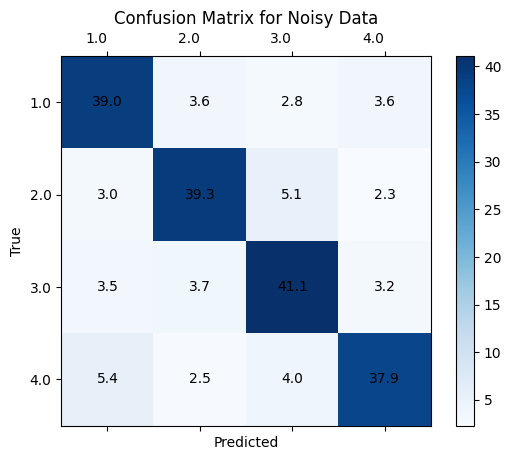

Results Summary for Noisy Data:
Average Accuracy: 0.7865
Precision per class:
  Class 1: 0.7662082514734774
  Class 2: 0.80040733197556
  Class 3: 0.7754716981132076
  Class 4: 0.8063829787234043
  Average Precision: 0.7871175650714123
Recall per class:
  Class 1: 0.7959183673469388
  Class 2: 0.7907444668008048
  Class 3: 0.7980582524271844
  Class 4: 0.7610441767068273
  Average Recall: 0.7864413158204389
F1 Score per class:
  Class 1: 0.7807807807807807
  Class 2: 0.7955465587044533
  Class 3: 0.7866028708133972
  Class 4: 0.7830578512396694



In [10]:
import matplotlib.pyplot as plt


def get_results_summary(metrics, dataset_type):
    summary = f"Results Summary for {dataset_type} Data:\n"
    summary += f"Average Accuracy: {metrics['average_accuracy']}\n"
    summary += "Precision per class:\n"
    for label, precision in metrics["precision"].items():
        if label == "avg":
            summary += f"  Average Precision: {precision}\n"
        else:
            summary += f"  Class {int(label)}: {precision}\n"
    summary += "Recall per class:\n"
    for label, recall in metrics["recall"].items():
        if label == "avg":
            summary += f"  Average Recall: {recall}\n"
        else:
            summary += f"  Class {int(label)}: {recall}\n"
    summary += "F1 Score per class:\n"
    for label, f1 in metrics["f1_score"].items():
        summary += f"  Class {int(label)}: {f1}\n"
    return summary


clean_plt = TreeEvaluator.visualise_confusion_matrix(clean_metrics["avg_confusion_matrix"],
                                                     clean_metrics["label_to_index"], "Confusion Matrix for Clean Data")
clean_plt.show()
print(get_results_summary(clean_metrics, "Clean"))

noisy_plt = TreeEvaluator.visualise_confusion_matrix(noisy_metrics["avg_confusion_matrix"],
                                                     noisy_metrics["label_to_index"], "Confusion Matrix for Noisy Data")
noisy_plt.show()
print(get_results_summary(noisy_metrics, "Noisy"))

### Best Trees Visualisation

#### Best tree on the clean dataset

Best clean tree depth: 12


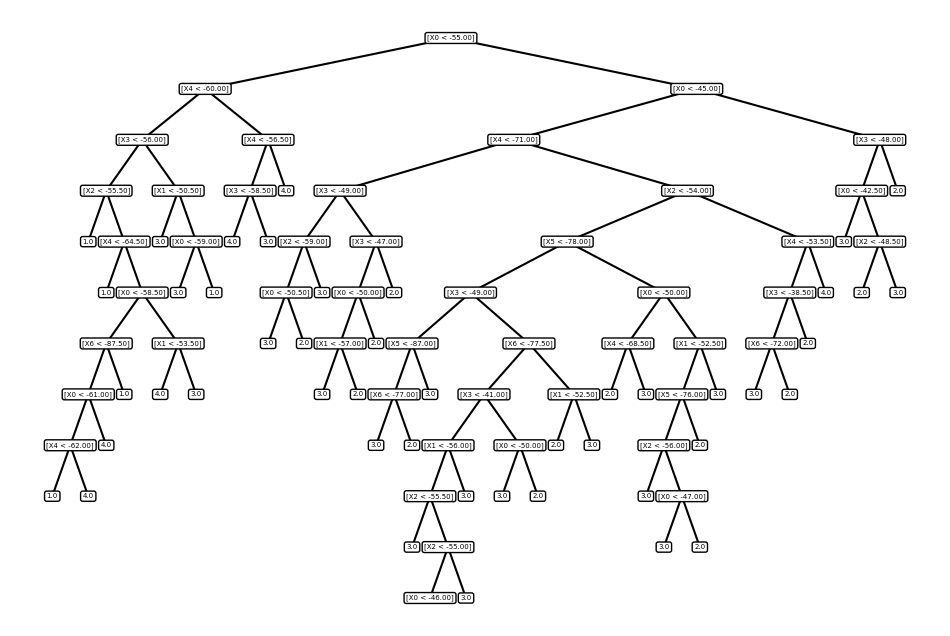

Feature 0 - Importance Score: 1.2878750071896767
Feature 4 - Importance Score: 0.5548134223913525
Feature 3 - Importance Score: 0.07989896779417265
Feature 2 - Importance Score: 0.03585296759251338
Feature 5 - Importance Score: 0.014879182618251649


In [11]:
best_clean_tree = clean_metrics["best_tree"]
plt = best_clean_tree.visualise(1, best_clean_tree.depth)
print(f"Best clean tree depth: {best_clean_tree.depth}")
plt.show()

top_k_features = best_clean_tree.get_top_k_features(k=5)
for feature_idx, importance_score in top_k_features:
    print(f"Feature {feature_idx} - Importance Score: {importance_score}")

#### Best tree on the noisy dataset

Best noisy tree depth: 20


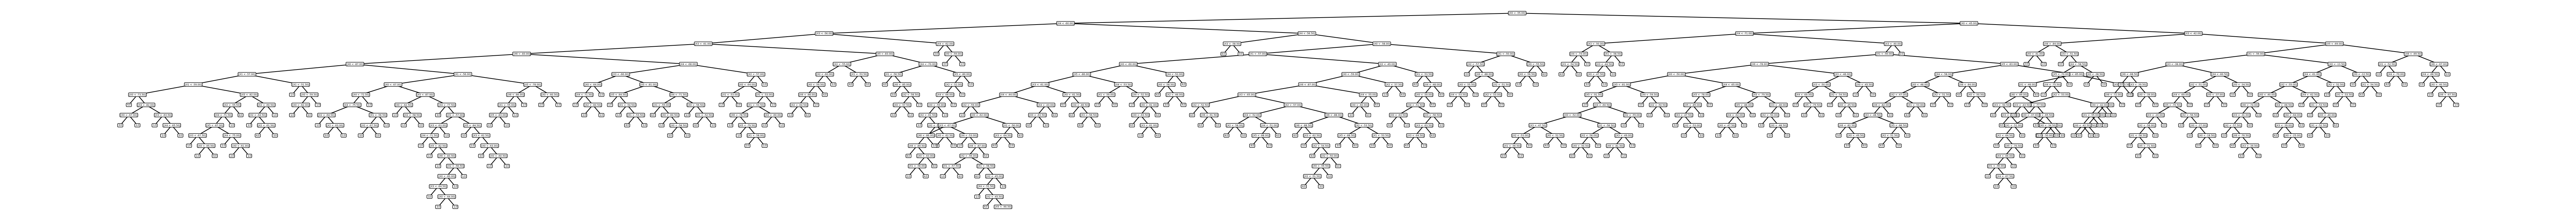

Feature 0 - Importance Score: 1.0390338294277253
Feature 4 - Importance Score: 0.4847756450934327
Feature 3 - Importance Score: 0.12859696882785684
Feature 2 - Importance Score: 0.09993571652622157
Feature 1 - Importance Score: 0.09491054154099487


In [12]:
best_noisy_tree = noisy_metrics["best_tree"]
plt = best_noisy_tree.visualise(8, best_noisy_tree.depth)
print(f"Best noisy tree depth: {best_noisy_tree.depth}")
plt.show()

top_k_features = best_noisy_tree.get_top_k_features(k=5)
for feature_idx, importance_score in top_k_features:
    print(f"Feature {feature_idx} - Importance Score: {importance_score}")

## Result Analysis

### Comment for both datasets on which rooms are correctly recognized, and which rooms are confused with others

Based on the precision and recall for the tree trained on the clean dataset across 10 folds, rooms are generally not confused (avg precision: 0.976, avg recall: 0.976). When it comes to the noisy dataset, classes are significantly more likely to be confused with each other as indicated by lower average precision and recall across all classes.

We observe that room 2 is occassionally confused with room 3 (and vice-versa) with 4.2% of room 2 classified as room 3 and 2.2% of room 3 classified as room 2. This is not surprising given that a Wifi signal sensor is present in Room 2 in close proximity to Room 3. This confusion is less prominent in the noisy dataset since classes are generally confused with each other across the board.

### Is there any difference in the performance when using the clean and noisy datasets? If yes/no explain why. 
For the tree trained on the noisy dataset, we observe that the number of false positive becomes much higher than its counterpart trained on the clean dataset. The test time accuracy of the noisy tree is thus also significantly lower.

This is again not surprising generally due to the noisy data containing granular information that is not necessary for good classification, nudging the tree towards overfitting on irrelevant noise.

This resulted in a much more complicated tree compared to the tree trained on the cleaned dataset (as seen in the visualised tree diagrams), an indication of an overfitted model with poor generalisation ability.

### Additional Observations
We observe that feature 0 (wifi signal emitted from emitter 0) is the most important feature for both decision trees based on total weighted information gain. On average, this single feature is twice as important as the next most important feature.